<a href="https://colab.research.google.com/github/Ganesh7331/Age_In_Minutes/blob/master/ganesh_work_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision efficientnet_pytorch pretrainedmodels -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cell 1: Imports and Setup
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [4]:
# Set up device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# # Copy the zip file from Google Drive
# !cp /content/drive/MyDrive/pranjal_dataset.zip /content/

# # Unzip the dataset in /content/
# !unzip /content/pranjal_dataset.zip -d /content/pranjal_dataset

In [6]:
# Data directory
data_dir = '/content/drive/MyDrive/capstone project/eardrumDs'

In [7]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all data
dataset = ImageFolder(data_dir, transform=transform)
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")

Number of classes: 3
Classes: ['Aom', 'Chornic', 'Normal']


In [8]:
# Split the dataset
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.25, random_state=42)

In [9]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 429
Validation samples: 143
Test samples: 144


In [10]:
# Initialize models

# MobileNet
mobilenet_model = models.mobilenet_v2(pretrained=True)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, len(dataset.classes))
mobilenet_model.to(device)

# RESNEXT
resnet_model = models.resnext50_32x4d(weights='IMAGENET1K_V2')
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(dataset.classes))
resnet_model.to(device)

# REGNET-X 16GF
regnet_x_16gf_model = models.regnet_x_16gf(weights='IMAGENET1K_V2')
regnet_x_16gf_model.fc = nn.Linear(regnet_x_16gf_model.fc.in_features, len(dataset.classes))
regnet_x_16gf_model.to(device)

# REGNET-Y-1-6GF
regnet_x_3_2gf_model = models.regnet_x_3_2gf(weights='IMAGENET1K_V1')
regnet_x_3_2gf_model.fc = nn.Linear(regnet_x_3_2gf_model.fc.in_features, len(dataset.classes))
regnet_x_3_2gf_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 105MB/s]
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M 

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            

In [11]:
from torch.amp import autocast, GradScaler

def train_model(model, optimizer, criterion, num_epochs):
    best_f1 = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_f1': []
    }
    scaler = GradScaler()  # Initialize mixed precision scaler

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with autocast(device_type='cuda'):  # Mixed precision training
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()  # Scale the loss for gradients
            scaler.step(optimizer)
            scaler.update()  # Update the scaler for next iteration

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            pbar.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_true = []
        y_pred = []

        with torch.no_grad():  # No gradient calculation in validation
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss / len(val_dataset)
        val_f1 = f1_score(y_true, y_pred, average='macro')

        # Save metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        # Save the best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best.pth")

        # Clear memory after each epoch
        torch.cuda.empty_cache()

    return model, history

In [12]:
# Train MobileNet
print("\nTraining MobileNet...")
mobilenet_optimizer = optim.AdamW(mobilenet_model.parameters(), lr=1e-4, weight_decay=1e-4)
mobilenet_criterion = nn.CrossEntropyLoss()
trained_mobilenet, mobilenet_history = train_model(mobilenet_model, mobilenet_optimizer, mobilenet_criterion, 15)

# Train ResNeXt (ResNeXt50_32x4d)
print("\nTraining ResNeXt50_32x4d...")
resnet_optimizer = optim.AdamW(resnet_model.parameters(), lr=5e-5, weight_decay=1e-4)
resnet_criterion = nn.CrossEntropyLoss()
trained_resnet, resnet_history = train_model(resnet_model, resnet_optimizer, resnet_criterion, 15)

# Train RegNet-X 16GF
print("\nTraining RegNet-X 16GF...")
regnet_x_optimizer = optim.AdamW(regnet_x_16gf_model.parameters(), lr=5e-5, weight_decay=1e-3)
regnet_x_criterion = nn.CrossEntropyLoss()
trained_regnet_x, regnet_x_history = train_model(regnet_x_16gf_model, regnet_x_optimizer, regnet_x_criterion, 15)

# Train RegNet-X 3.2GF
print("\nTraining RegNet-X 3.2GF...")
regnet_x_3_2gf_optimizer = optim.AdamW(regnet_x_3_2gf_model.parameters(), lr=5e-5, weight_decay=1e-3)
regnet_x_3_2gf_criterion = nn.CrossEntropyLoss()
trained_regnet_x_3_2gf, regnet_x_3_2gf_history = train_model(regnet_x_3_2gf_model, regnet_x_3_2gf_optimizer, regnet_x_3_2gf_criterion, 15)


Training MobileNet...


Epoch 1/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/14 [00:00<?, ?it/s]


Training ResNeXt50_32x4d...


Epoch 1/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/14 [00:00<?, ?it/s]


Training RegNet-X 16GF...


Epoch 1/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/14 [00:00<?, ?it/s]


Training RegNet-X 3.2GF...


Epoch 1/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/14 [00:00<?, ?it/s]

In [13]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

In [14]:
# Evaluate each model on the test set and store the results
models = {
    'MobileNet': trained_mobilenet,
    'resnext': trained_resnet,
    'regnet_x_16gf': trained_regnet_x,
    'regnet_x_3_2gf': trained_regnet_x_3_2gf,
}

results = []
for model_name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
    results.append([model_name, accuracy, precision, recall, f1])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print("Model Evaluation Results:")
print(results_df)

Model Evaluation Results:
            Model  Accuracy  Precision    Recall  F1 Score
0       MobileNet  0.923611   0.944949  0.839349  0.884195
1         resnext  0.847222   0.878261  0.681004  0.742371
2   regnet_x_16gf  0.868056   0.885870  0.757927  0.808792
3  regnet_x_3_2gf  0.875000   0.931548  0.736516  0.802642


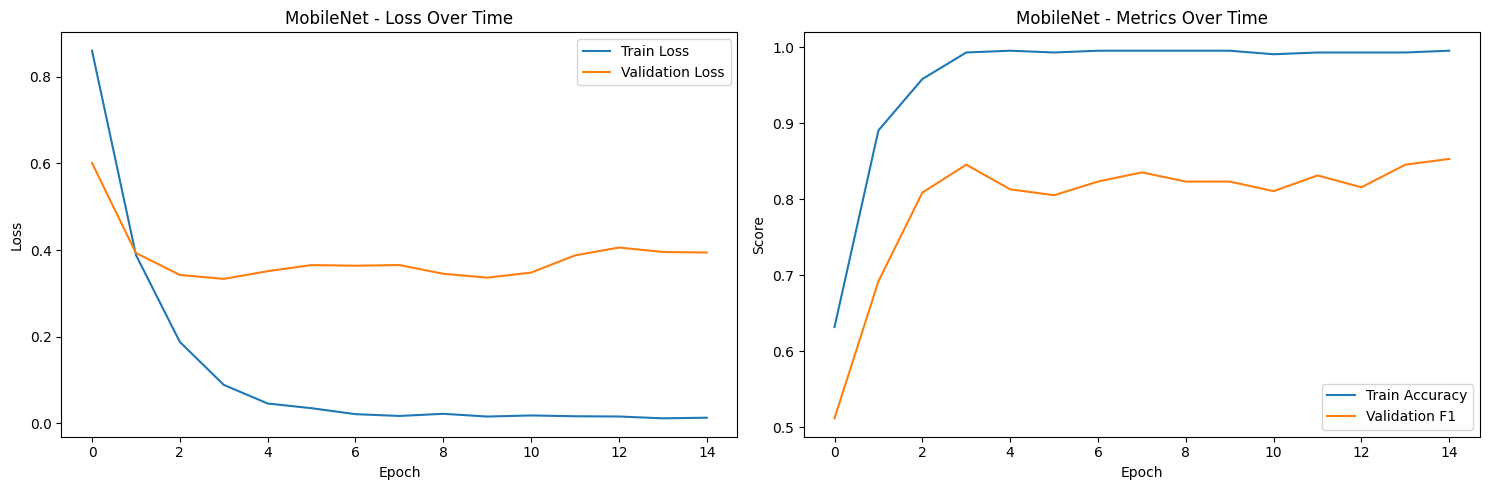

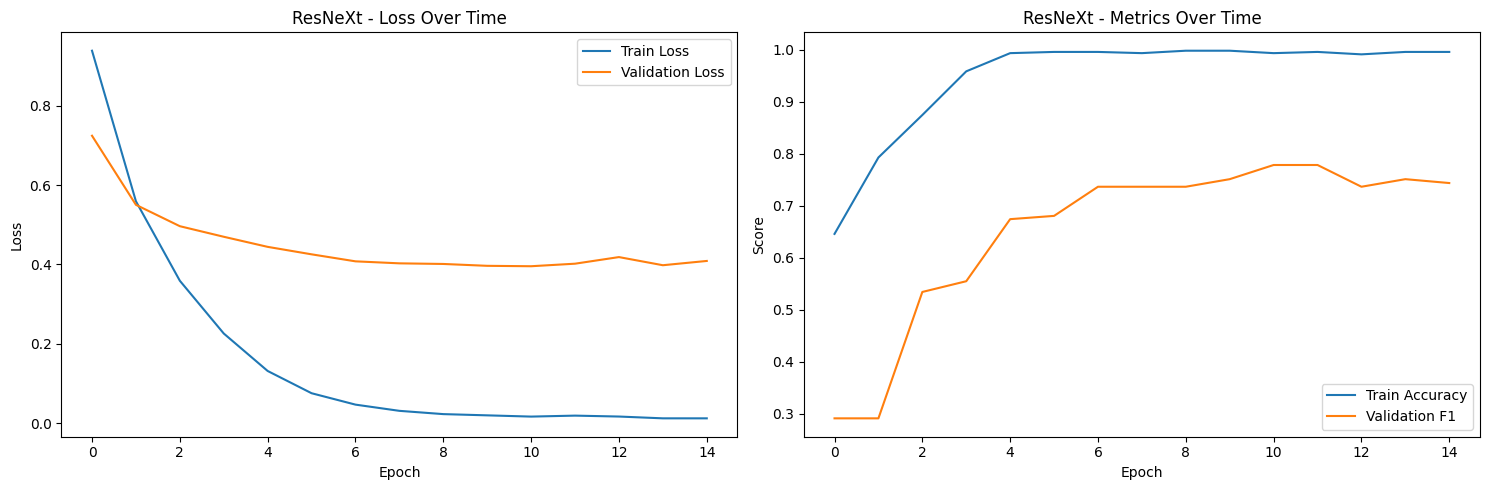

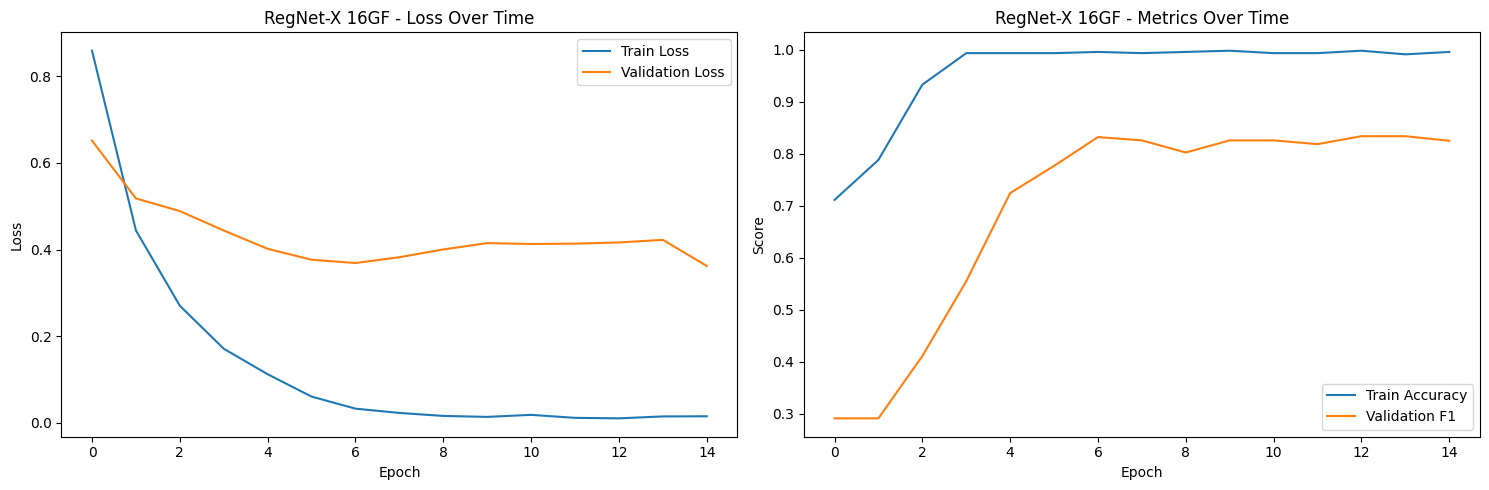

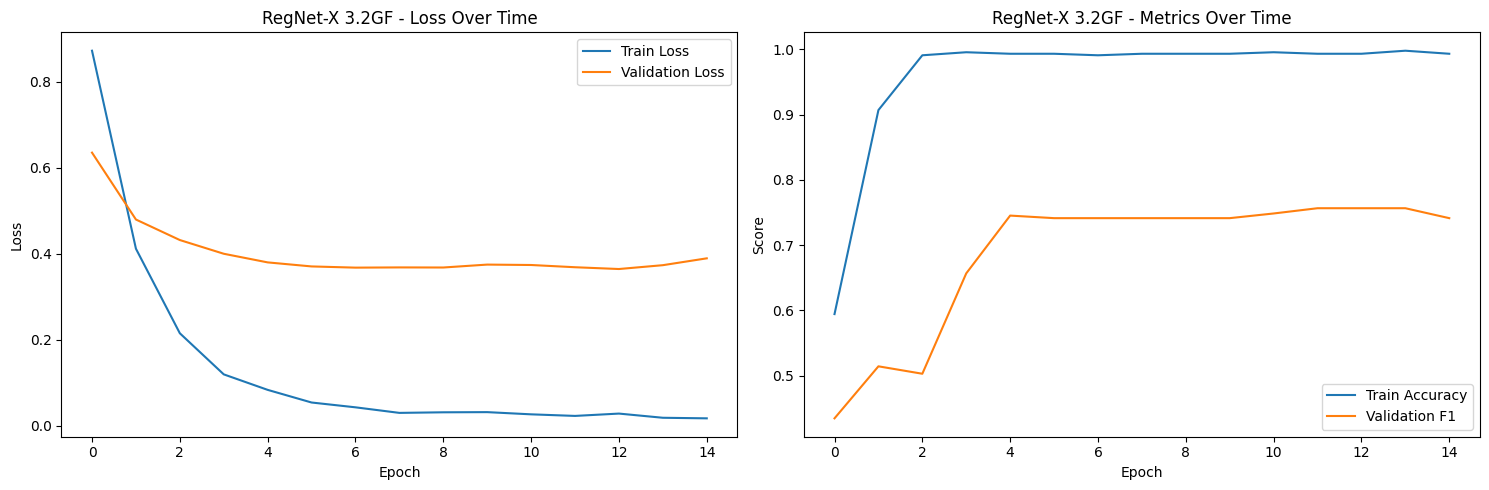

In [15]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot metrics
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_f1'], label='Validation F1')
    ax2.set_title(f'{model_name} - Metrics Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_training_history(mobilenet_history, 'MobileNet')
plot_training_history(resnet_history, 'ResNeXt')
plot_training_history(regnet_x_history, 'RegNet-X 16GF')
plot_training_history(regnet_x_3_2gf_history, 'RegNet-X 3.2GF')

In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensemble prediction function
def ensemble_predict(inputs):
    # Sequential prediction to save memory
    with torch.no_grad():
        mobilenet_output = trained_mobilenet(inputs)
        torch.cuda.empty_cache()  # Clear memory after the first model
        resnext_output = trained_resnet(inputs)
        torch.cuda.empty_cache()  # Clear memory after the second model
        regnet_x_output = trained_regnet_x(inputs)
        torch.cuda.empty_cache()  # Clear memory after the third model
        regnet_x_3_2gf_output = trained_regnet_x_3_2gf(inputs)
        torch.cuda.empty_cache()  # Clear memory after the fourth model

        # Ensemble average (equal weights for each model)
        ensemble_output = (mobilenet_output + regnet_x_output + resnext_output) / 3

    _, preds = torch.max(ensemble_output, 1)
    return preds

# Evaluate ensemble model on the test set
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating ensemble'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        preds = ensemble_predict(inputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate metrics for the ensemble model
test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"Ensemble Model Test Accuracy: {test_accuracy:.4f}")
print(f"Ensemble Model Test F1-Score: {test_f1:.4f}")
print(f"Ensemble Model Test Precision: {precision:.4f}")
print(f"Ensemble Model Test Recall: {recall:.4f}")

Evaluating ensemble:   0%|          | 0/5 [00:00<?, ?it/s]

Ensemble Model Test Accuracy: 0.8889
Ensemble Model Test F1-Score: 0.8342
Ensemble Model Test Precision: 0.9084
Ensemble Model Test Recall: 0.7842


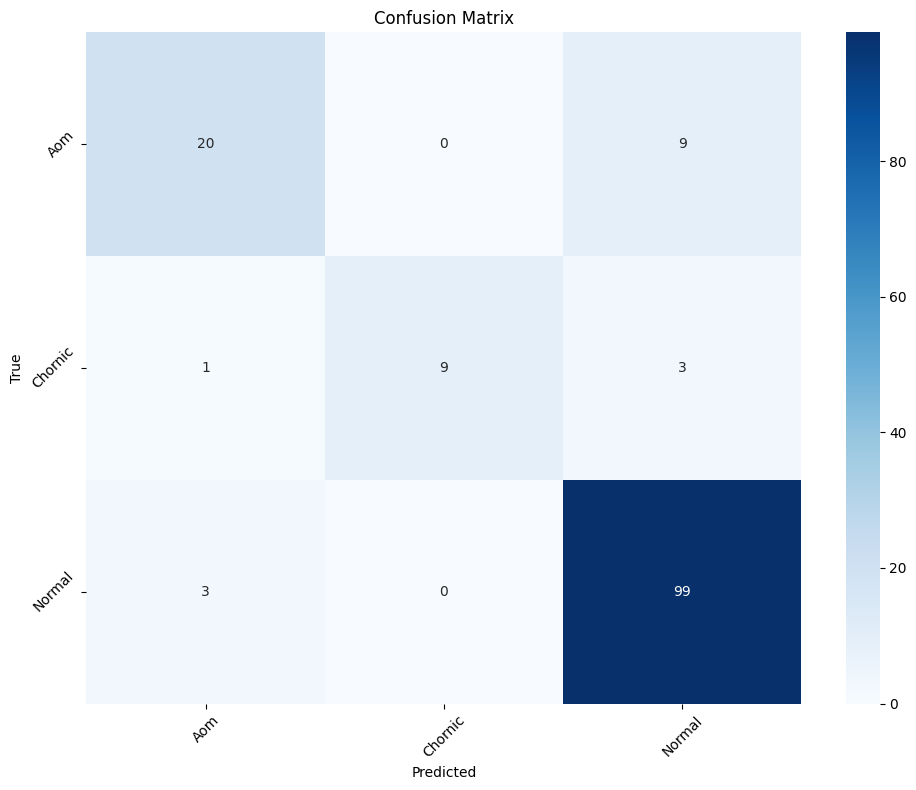

In [17]:
# Cell 8: Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()